# Stock Return Prediction

## Problem Definition

In this supervised regression framework, we will predict the weekly return of Microsoft (MSFT). We want to understand what affects the Microsoft stock price.

We will use the stock price of its competitors (which are other big tech companies), the indices associates with USA and tech sector, and some currency exchange rate involved USD. In particular, we will use these independent variables:
- Stocks: Amazon (AMZN), Google (GOOGL), IBM (IBM), Apple (AAPL)
- Currency: USD/JPY and GBP/USD
- Indices: S&P 500, Dow Jones, Nasdaq 100

## Loading the data and required packages

### Loading the packages

For supervised regression models

In [1]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

For data analysis and model evaluation

In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import chi2, f_regression, SelectKBest

For deep learning models

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasRegressor

2024-09-03 15:36:25.405611: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-03 15:36:25.414896: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 15:36:25.486164: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 15:36:25.553371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 15:36:25.615205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

For time series models

In [4]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

For data preparation and visualization

In [5]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from yahoo import historical_stocks_data

### Loading the data

Now, we will extract the data using the `pandas_datareader` library. 

In [6]:
stock_tickers = ["MSFT", "GOOGL", "IBM"]
currency_tickers = ["DEXJPUS", "DEXUSUK"]
index_tickers = ["SP500", "DJIA", "NASDAQ100"]

from datetime import datetime
from dateutil.relativedelta import relativedelta
begin_date = datetime.now() - relativedelta(years=10, days=-1)

# Uncomment the 6 lines below when run the first time
# currency_data:pd.DataFrame = web.DataReader(currency_tickers, "fred", start=begin_date, end=datetime.now())
# index_data:pd.DataFrame = web.DataReader(index_tickers, "fred", start=begin_date, end=datetime.now())
# stock_data:pd.DataFrame = historical_stocks_data(stock_tickers)
# currency_data.to_csv("./data/currency_data.csv")
# index_data.to_csv("./data/index_data.csv")
# stock_data.to_csv("./data/stock_data.csv")

currency_data = pd.read_csv("./data/currency_data.csv", index_col="DATE")
index_data = pd.read_csv("./data/index_data.csv", index_col="DATE")
stock_data = pd.read_csv("./data/stock_data.csv", index_col="Date")

Next, we need to choose a time frame to predict. We will predict weekly returns. Hence, we would use 5 business days (stock exchange is stopped in Saturday and Sunday).

In [7]:
return_period = 5

SELF_BUSINESS_RETURNS_DAYS = [5, 15, 30, 60]

We now define the independent variables and dependent variable:

Y: 

MSFT Future Returns (in the next 5 days)

X:
```
    GOOGL 5 Business Day Returns
    ISM 5 Business Day Returns
    USD/JPY 5 Business Day Returns
    GBP/USD 5 Business Day Returns
    S&P 500 5 Business Day Returns
    DOW JONES 5 Business Day Returns
    MSFT 5 Business Day Returns
    MSFT 15 Business Day Returns
    MSFT 30 Business Day Returns
    MSFT 60 Business Day Returns
```

In [8]:
stock_data

,MSFT,GOOGL,IBM
Date,,,
2014-09-02,38.552803,29.397760,119.103828
2014-09-03,38.441647,29.442209,119.346291
2014-09-04,38.698154,29.623001,118.556656
2014-09-05,39.253925,29.854736,118.879936
2014-09-08,39.732750,30.047014,118.220840
...,...,...,...
2024-08-26,413.489990,166.160004,197.979996
2024-08-27,413.839996,164.679993,198.729996
2024-08-28,410.600006,162.850006,198.460007


In [9]:
y = np.log(stock_data.loc[:, "MSFT"]).diff(return_period).shift(-return_period)
y.name += "_pred"
# y = pd.concat([pd.to_datetime(stock_data["Date"]), y], axis=1)
# y.set_index("Date", inplace=True)
y

Date
2014-09-02    0.036367
2014-09-03    0.040964
2014-09-04    0.037724
2014-09-05    0.017061
2014-09-08   -0.004962
                ...   
2024-08-26         NaN
2024-08-27         NaN
2024-08-28         NaN
2024-08-29         NaN
2024-08-30         NaN
Name: MSFT_pred, Length: 2517, dtype: float64

In [10]:

X1 = np.log(stock_data.loc[:, ("GOOGL", "IBM")]).diff(return_period)
X2 = np.log(currency_data).diff(return_period)
X3 = np.log(index_data).diff(return_period)

X4 = pd.concat(
    [np.log(stock_data.loc[:, "MSFT"]).diff(i) for i in SELF_BUSINESS_RETURNS_DAYS]
    , axis=1).dropna()
X4.columns = [f"MSFT_{i}DR" for i in SELF_BUSINESS_RETURNS_DAYS]

X = pd.concat([X1, X2, X3, X4], axis=1).dropna()
X.head(10)

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,NASDAQ100,MSFT_5DR,MSFT_15DR,MSFT_30DR,MSFT_60DR
2014-11-25,0.008631,-0.000803,0.010479,0.004209,0.007395,0.007161,0.010794,-0.026402,0.004183,0.088351,0.057725
2014-11-26,0.000968,0.003216,-0.000850,0.007439,0.011700,0.007998,0.022325,-0.009795,0.003986,0.105963,0.066493
2014-11-28,0.009736,0.009479,0.008120,-0.002172,0.001966,0.001020,0.020133,-0.018444,-0.012157,0.118387,0.061099
2014-12-01,-0.011497,0.003845,-0.002114,0.002671,-0.007747,-0.002309,0.000814,0.013250,0.005054,0.114577,0.063639
2014-12-02,-0.016371,0.003202,0.009364,-0.004017,-0.000232,0.003620,0.004126,0.018116,-0.002547,0.101020,0.048219
2014-12-03,-0.022575,0.016918,0.018702,-0.005526,0.000723,0.004749,-0.001173,0.012768,-0.010010,0.075161,0.034126
2014-12-05,-0.038996,0.006760,0.022327,-0.002433,0.003770,0.007296,-0.006061,0.012678,-0.017992,0.079094,0.036053
2014-12-08,-0.016667,0.001979,0.023011,-0.007524,0.003340,0.004248,-0.002211,-0.019104,-0.032369,0.039755,0.027474
2014-12-09,-0.004615,0.001965,-0.001933,0.002744,-0.003262,-0.004392,-0.002625,-0.018116,-0.032254,0.042227,0.035065
2014-12-10,-0.016770,-0.024676,-0.011078,-0.000701,-0.023506,-0.021412,-0.020629,-0.024849,-0.038482,0.015068,0.009277


In [11]:
np.log(currency_data)

,DEXJPUS,DEXUSUK
DATE,,
2014-09-03,4.652817,0.497801
2014-09-04,4.656053,0.491582
2014-09-05,4.653389,0.489316
2014-09-08,4.660132,0.478778
2014-09-09,4.666453,0.475489
...,...,...
2024-08-19,4.986479,0.261133
2024-08-20,4.981550,0.264439
2024-08-21,4.978043,0.268270


In [12]:
dataset = pd.concat([X, y], axis=1).dropna().iloc[::return_period, :]
X = dataset.loc[:, X.columns]
y = dataset.loc[:, y.name]
dataset

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,NASDAQ100,MSFT_5DR,MSFT_15DR,MSFT_30DR,MSFT_60DR,MSFT_pred
2014-11-25,0.008631,-0.000803,0.010479,0.004209,0.007395,0.007161,0.010794,-0.026402,0.004183,0.088351,0.057725,0.012768
2014-12-03,-0.022575,0.016918,0.018702,-0.005526,0.000723,0.004749,-0.001173,0.012768,-0.010010,0.075161,0.034126,-0.024849
2014-12-11,-0.019485,-0.018332,-0.002259,0.000318,-0.017818,-0.017115,-0.015295,-0.034792,-0.022016,0.018016,0.020163,0.007393
2014-12-18,-0.033421,-0.021271,-0.004701,-0.003187,0.012645,0.010279,0.005001,0.007393,-0.004828,-0.000842,0.015590,0.007547
2014-12-29,0.032669,0.012539,0.006073,-0.006037,0.005771,0.004378,0.004408,-0.004416,-0.020236,-0.038228,0.042554,-0.038673
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,-0.060371,0.035847,-0.019297,-0.006884,-0.026568,-0.018113,-0.045395,-0.051177,-0.096461,-0.033561,0.041166,-0.003088
2024-08-01,0.020590,-0.012158,-0.025723,-0.008731,0.008752,0.010286,0.003171,-0.003088,-0.086288,-0.067731,0.010398,-0.035183
2024-08-08,-0.052478,0.015434,-0.020059,-0.002430,-0.023663,-0.022596,-0.025552,-0.035183,-0.089448,-0.115869,-0.025220,0.046338
2024-08-15,-0.004515,0.015641,0.012365,0.009530,0.041232,0.027913,0.056808,0.046338,0.008067,-0.088394,-0.008384,-0.013101


# Data Visualization

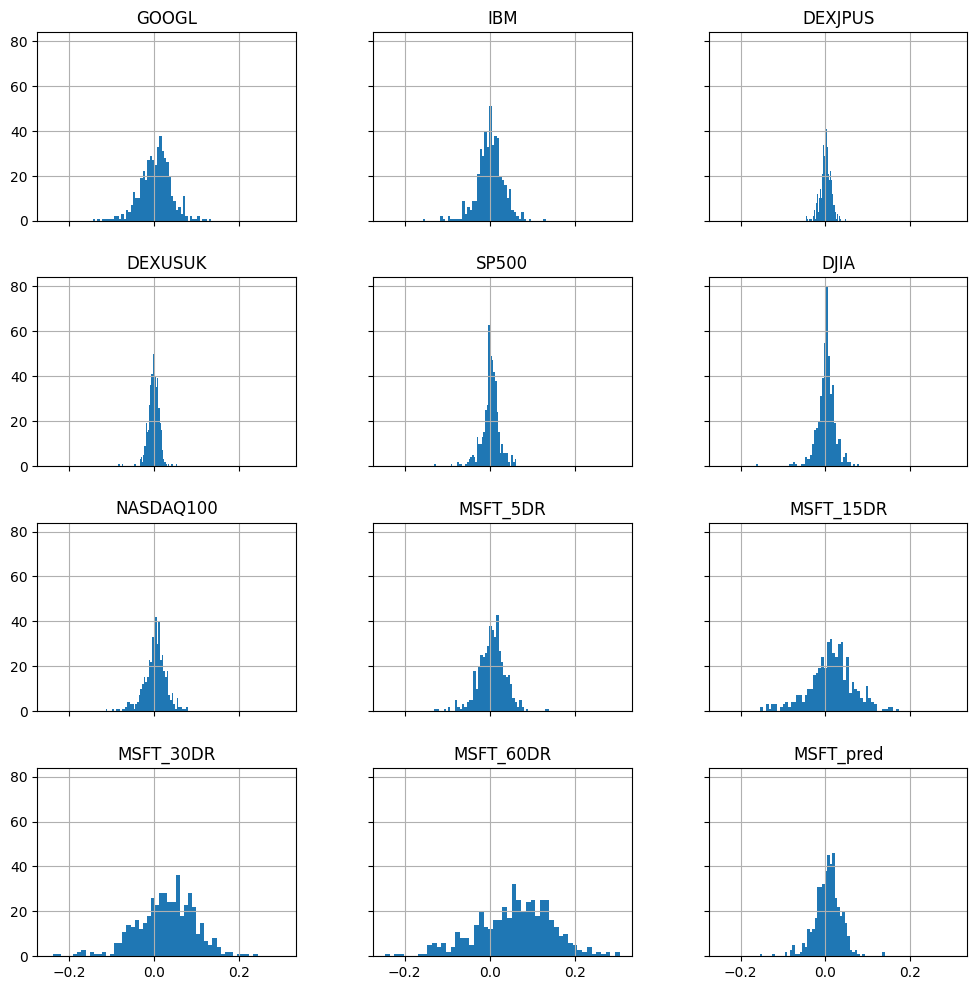

In [13]:
dataset.hist(bins=50, sharex=True, sharey=True, figsize=(12, 12))
plt.show()

<Axes: title={'center': 'Correlation matrix'}>

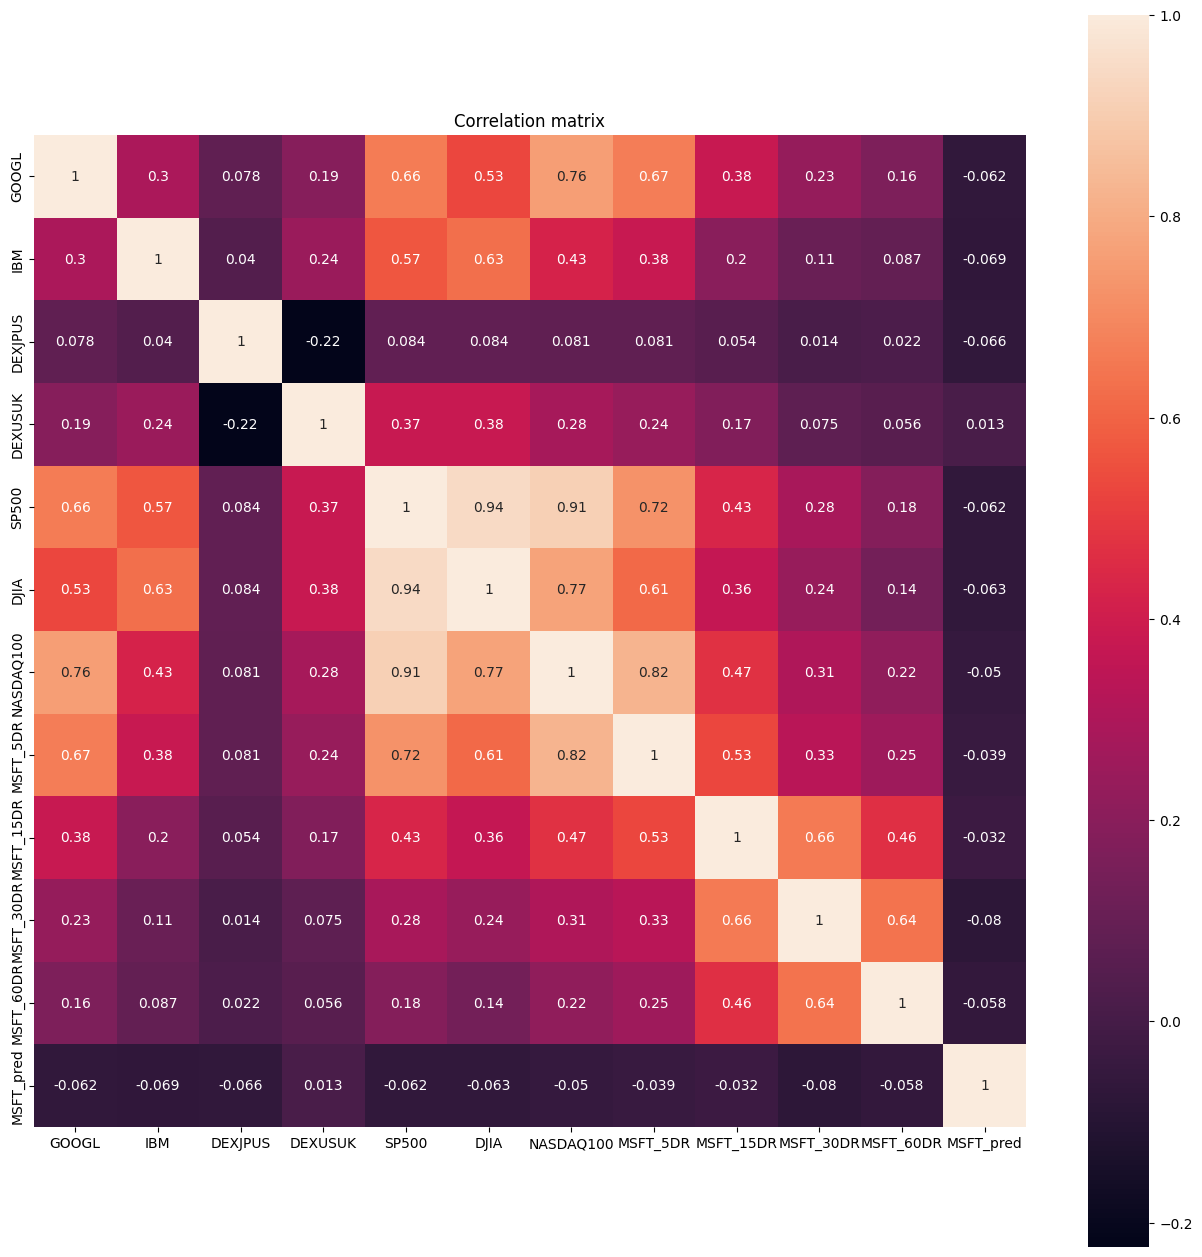

In [14]:
correlation = dataset.corr()
plt.figure(figsize=(16, 16))
plt.title("Correlation matrix")
sns.heatmap(correlation, square=True, annot=True, vmax=1)

<Figure size 1600x1600 with 0 Axes>

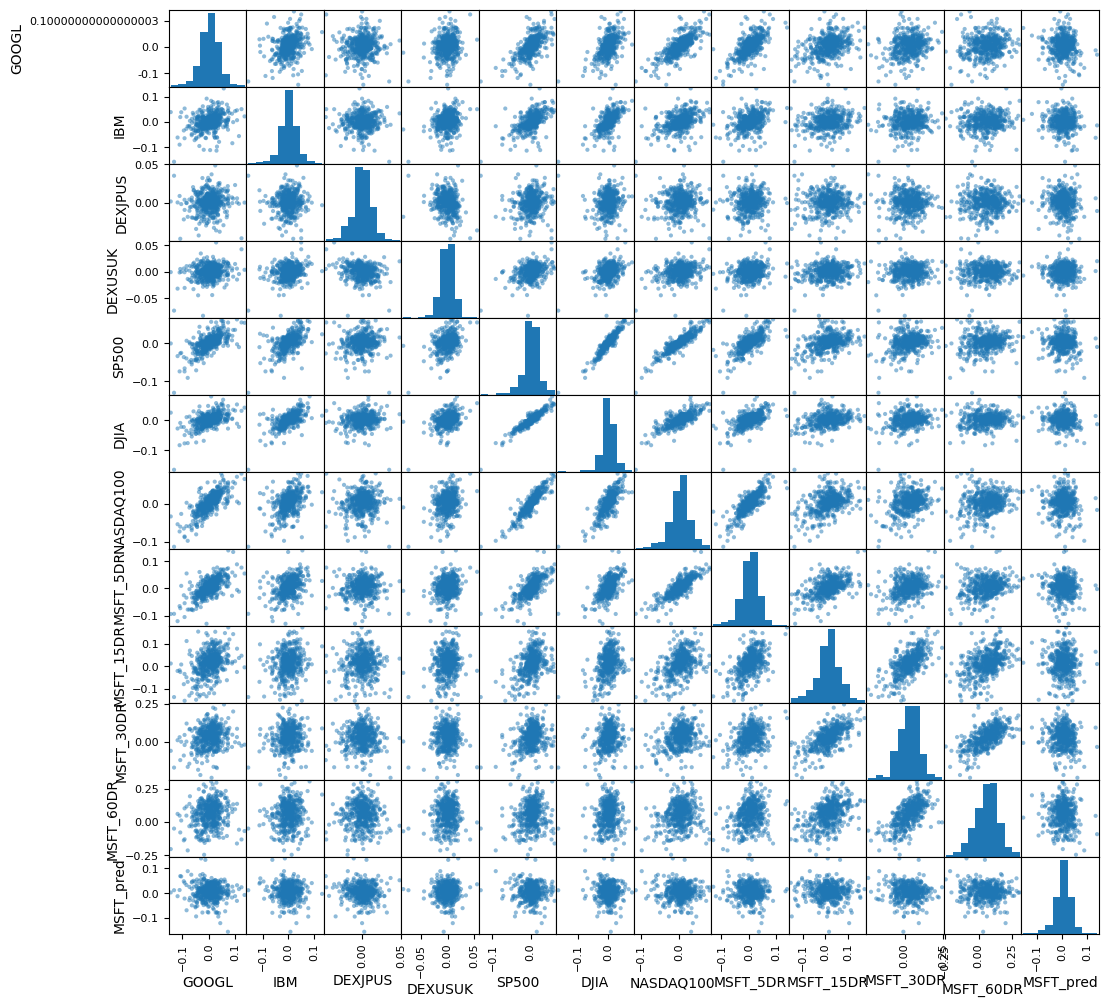

In [15]:
plt.figure(figsize=(16, 16))
scatter_matrix(dataset, figsize=(12, 12))
plt.show()

# Time series analysis

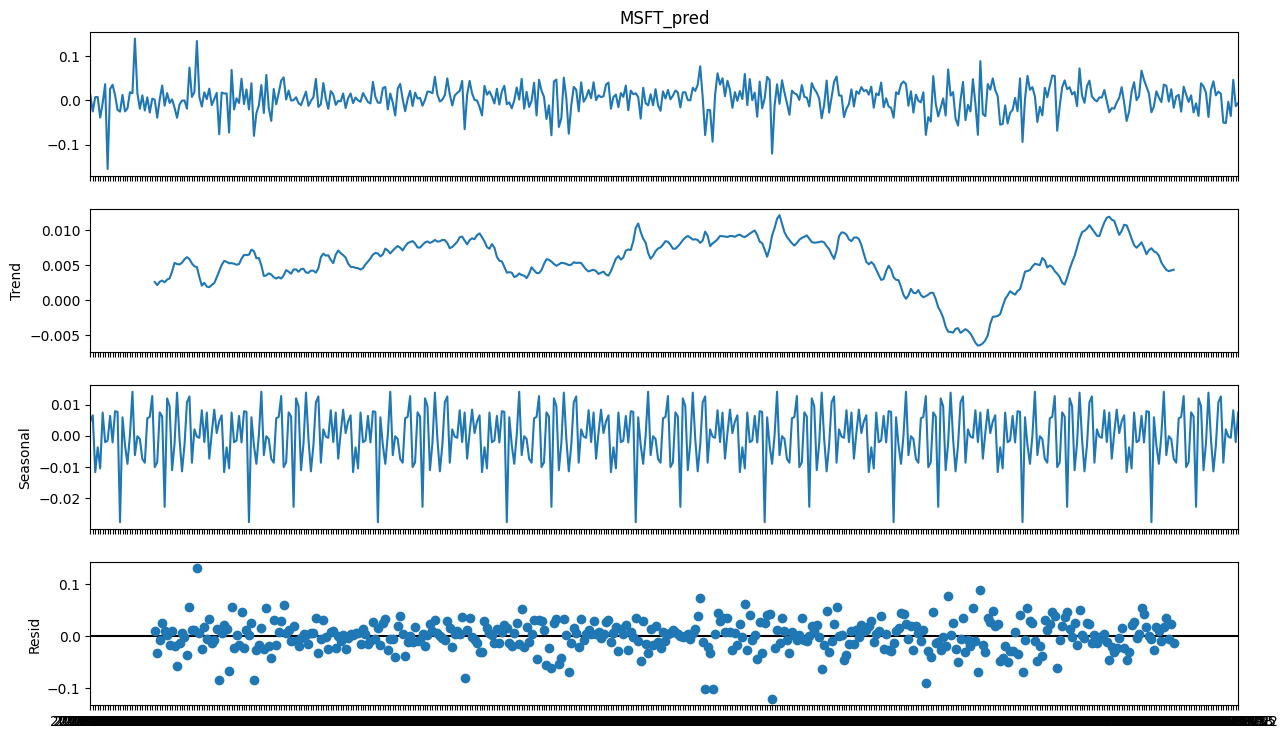

In [16]:
decomposition = sm.tsa.seasonal_decompose(y, period=52)
fig = decomposition.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

# Feature Selection

In [17]:
best_features = SelectKBest(k=5, score_func=f_regression)
fit = best_features.fit(X, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ["Feature", "Score"]
feature_scores.sort_values(by="Score", ascending=False)

,Feature,Score
9,MSFT_30DR,2.999636
1,IBM,2.222683
2,DEXJPUS,2.002019
5,DJIA,1.828614
4,SP500,1.806454
0,GOOGL,1.783296
10,MSFT_60DR,1.580149
6,NASDAQ100,1.150992
7,MSFT_5DR,0.706651
8,MSFT_15DR,0.476509


# Train/Test split and evaluation metric

In [18]:
valid_size = 0.2

train_size = int(len(X) * (1 - valid_size))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [19]:
num_folds = 10
seed = 42
scoring = "neg_mean_squared_error"

# Compare models and algorithms

In [20]:
models = []
models.append(("Linear", LinearRegression()))
models.append(("Lasso", Lasso()))
models.append(("Elastic", ElasticNet()))
models.append(("KNN", KNeighborsRegressor()))
models.append(("CART", DecisionTreeRegressor()))
models.append(("SVR", SVR()))
models.append(("MLP", MLPRegressor()))
models.append(("ABR", AdaBoostRegressor()))
models.append(("GBR", GradientBoostingRegressor()))
models.append(("RFR", RandomForestRegressor()))
models.append(("ETR", ExtraTreesRegressor()))

In [21]:
names = []
k_fold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    k_fold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

    cv_result = -1*cross_val_score(model, X_train, y_train, scoring=scoring, cv=k_fold)
    
    k_fold_results.append(cv_result)

    trained_model = model.fit(X_train, y_train)
    train_result = mean_squared_error(trained_model.predict(X_train), y_train)
    train_results.append(train_result)

    test_result = mean_squared_error(trained_model.predict(X_test), y_test)
    test_results.append(test_result)

    print(f"{name}: Mean: {cv_result.mean()} Std: {cv_result.std()} Train MSE: {train_result}, Test MSE: {test_result}")

Linear: Mean: 0.0010693282619734347 Std: 0.0004380074165382464 Train MSE: 0.0009864417869504055, Test MSE: 0.0010687230026873032
Lasso: Mean: 0.0010292177353558648 Std: 0.00043897748143861804 Train MSE: 0.0010251111524883663, Test MSE: 0.0009239075826980421
Elastic: Mean: 0.0010292177353558648 Std: 0.00043897748143861804 Train MSE: 0.0010251111524883663, Test MSE: 0.0009239075826980421
KNN: Mean: 0.0012321940831294762 Std: 0.0004246546111128695 Train MSE: 0.0007989126205174506, Test MSE: 0.0012026209629697746
CART: Mean: 0.0022541622143274183 Std: 0.0004350654574614152 Train MSE: 0.0, Test MSE: 0.001833015468509851
SVR: Mean: 0.0014654029166897289 Std: 0.0005353751141124514 Train MSE: 0.0012557350169052068, Test MSE: 0.0013481236734384603
MLP: Mean: 0.001229203432410416 Std: 0.0004790669474554351 Train MSE: 0.0011436728447295024, Test MSE: 0.001088012197765511
ABR: Mean: 0.0011695832481144854 Std: 0.00036365058846112133 Train MSE: 0.0007480870006122796, Test MSE: 0.0011936724196840846


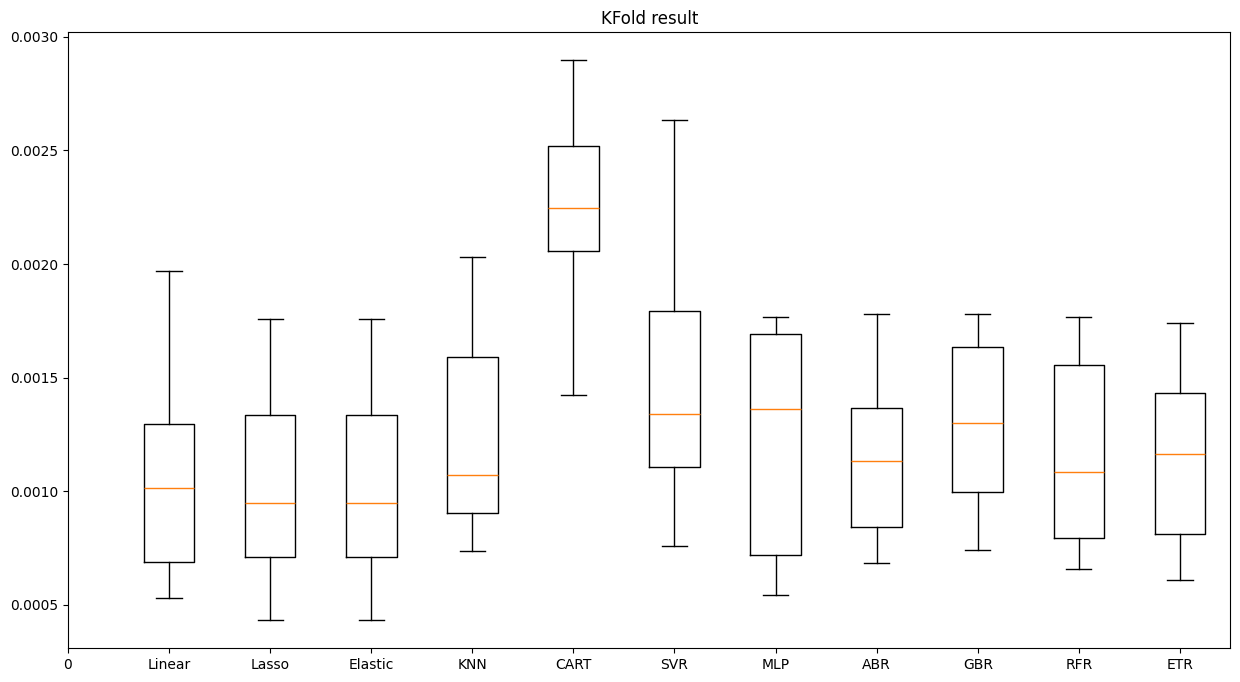

In [22]:
plt.figure(figsize=(15, 8))
plt.title("KFold result")
plt.boxplot(k_fold_results)
plt.xticks(ticks=range(len(names)+1) ,labels=[0]+names)
plt.show()

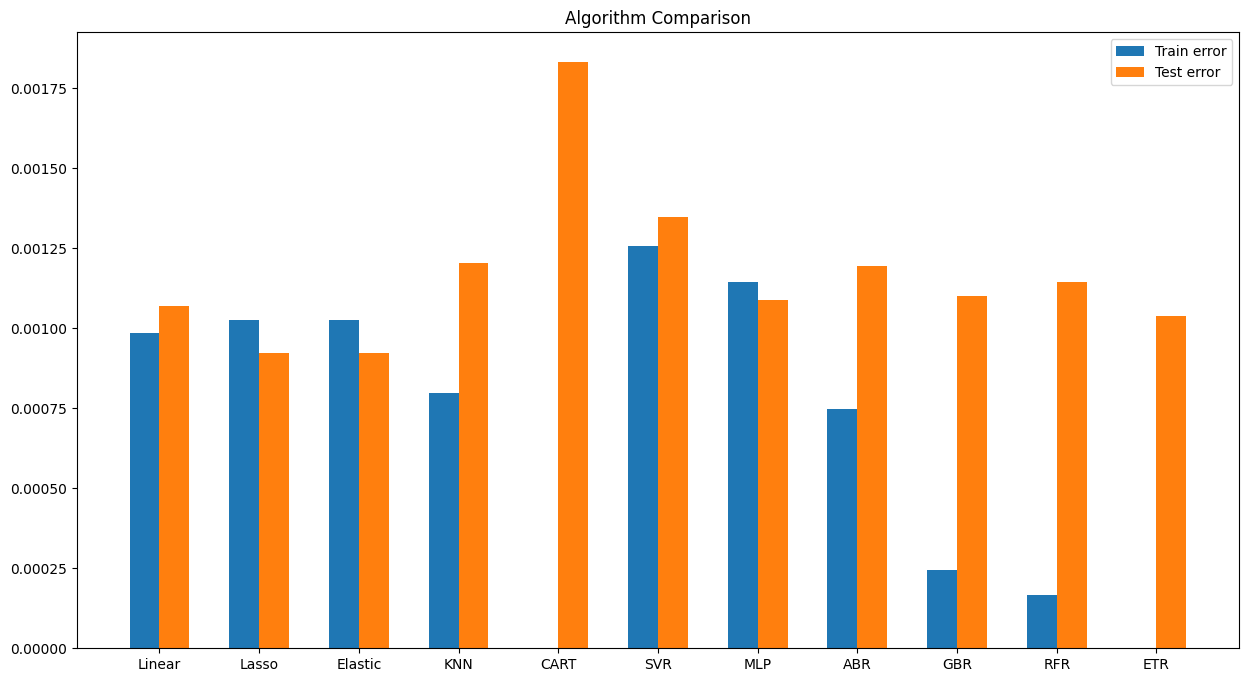

In [23]:
plt.figure(figsize=(15, 8))

index = np.arange(len(names))
width = 0.3

plt.title("Algorithm Comparison")
plt.bar(index-width/2, train_results, width=width, label="Train error")
plt.bar(index+width/2, test_results, width=width, label="Test error")

plt.xticks(ticks=range(len(train_results)), labels=names)
plt.legend()
plt.show()

# Time Series Based models: ARIMA and LSTM

In [24]:
ARIMA_columns = [feature for feature in X.columns.to_list() if "MSFT" not in feature]
X_train_ARIMA = X_train.loc[:, ARIMA_columns]
X_test_ARIMA = X_test.loc[:, ARIMA_columns]

In [25]:
ARIMA_model = ARIMA(endog=y_train, exog=X_train_ARIMA, order=(1, 0, 0))
ARIMA_model = ARIMA_model.fit()

/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
error_ARIMA = mean_squared_error(y_train, ARIMA_model.predict(exog=X_train_ARIMA))
predict = ARIMA_model.predict(start=len(X_train_ARIMA)-1, end=len(X)-1, exog=X_test_ARIMA)[1:]
error_test_ARIMA = mean_squared_error(y_test, predict)

/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# LSTM model

We are dealing with time series model. In this notebook, `seq_len` means the length of the whole sequence, which means the length of the predict sequence of days and the day we forecast. Here we use a day to forecast the next day.

In [27]:
seq_len = 2

y_train_LSTM, y_test_LSTM = np.array(y_train)[seq_len-1:], np.array(y_test)
X_train_LSTM = np.zeros([X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]])
X_test_LSTM = np.zeros([X_test.shape[0], seq_len, X_test.shape[1]])
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i , :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [28]:
def create_LSTMmodel(neurons=12, learn_rate=0.01, momentum=0) -> Sequential:
    model = Sequential(
        [   
            InputLayer([X_train_LSTM.shape[1], X_train_LSTM.shape[2]]),
            LSTM(50),
            Dense(1),
        ]
    )
    model.compile(loss="mse", optimizer="adam")
    return model
LSTMmodel = create_LSTMmodel(12, learn_rate=0.01, momentum=0)
history = LSTMmodel.fit(X_train_LSTM, y_train_LSTM, validation_data=(X_test_LSTM, y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

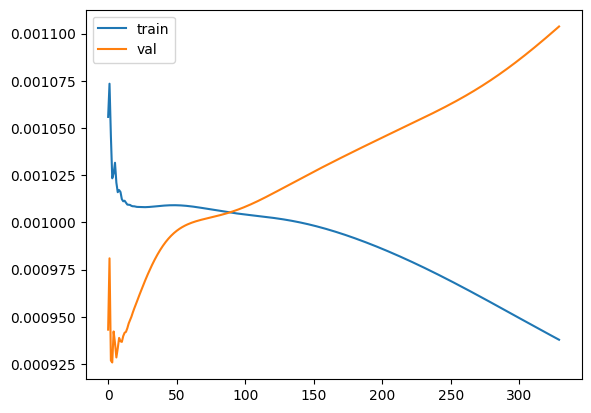

In [29]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

In [30]:
error_LSTM = mean_squared_error(y_train_LSTM, LSTMmodel.predict(X_train_LSTM))
error_test_LSTM = mean_squared_error(y_test_LSTM, LSTMmodel.predict(X_test_LSTM))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [31]:
test_results.append(error_test_ARIMA)
test_results.append(error_test_LSTM)

train_results.append(error_ARIMA)
train_results.append(error_LSTM)

names.append("ARIMA")
names.append("LSTM")

# Comparison of all the algorithms (including Time Series Algorithms)

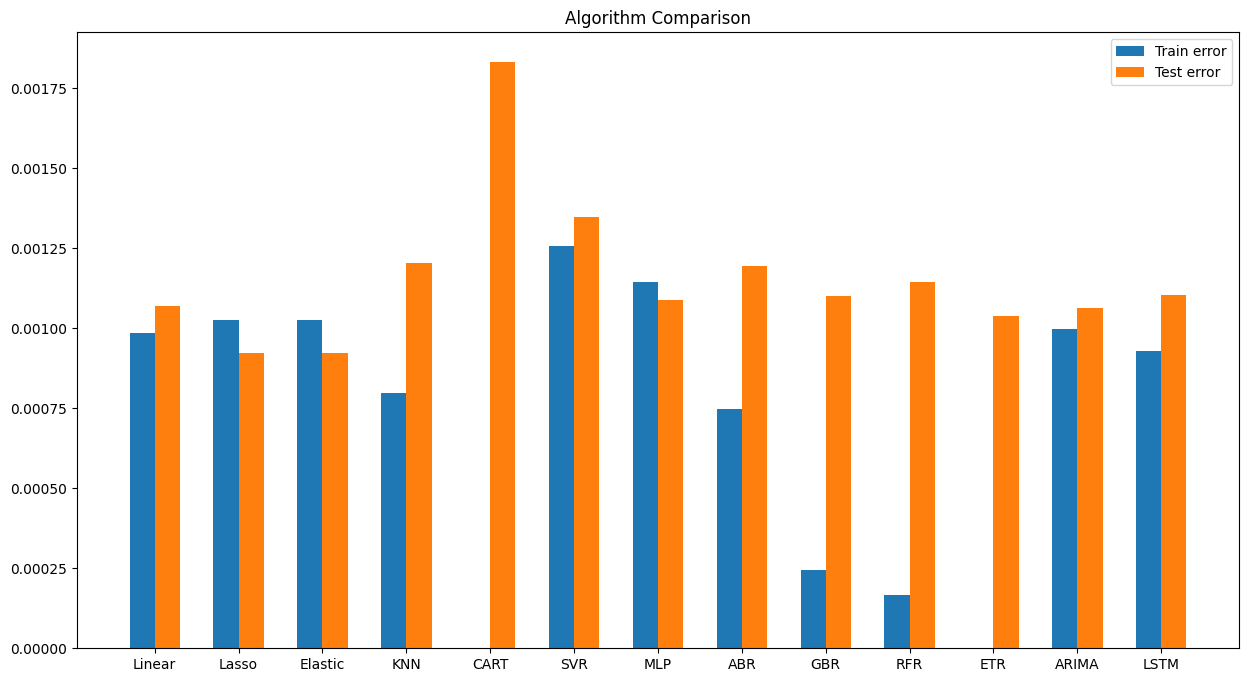

In [32]:
plt.figure(figsize=(15, 8))

index = np.arange(len(names))
width = 0.3

plt.title("Algorithm Comparison")
plt.bar(index-width/2, train_results, width=width, label="Train error")
plt.bar(index+width/2, test_results, width=width, label="Test error")

plt.xticks(ticks=range(len(train_results)), labels=names)
plt.legend()
plt.show()

# Fine tune the model using grid search

In [33]:
def evaluate_ARIMA_model(order: tuple[int]) -> float:
    ARIMA_model = ARIMA(endog=y_train, exog=X_train_ARIMA, order=order)
    ARIMA_model.fit()
    error = mean_squared_error(y_train, ARIMA_model.predict(X_train_ARIMA))
    return error

def evaluate_model(p_values, d_values, q_values) -> tuple[int]:
    best_score, best_order = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_order = mse, order
                except:
                    continue
    print(f"Best order {order}")

import warnings
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]
warnings.filterwarnings("ignore")
evaluate_model(p_values, d_values, q_values)

Best order (2, 1, 1)


# Test the model

In [34]:
# prepare model
model_fit_tuned = ARIMA(endog=y_train, exog=X_train_ARIMA, order=[2, 1, 1]).fit()

# estimate accuracy on validation set
predicted_tuned = model_fit_tuned.predict(start = len(X_train) -1 ,end = len(X) -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(y_test,predicted_tuned))

0.001160436261787585


In [37]:
len(X_train_ARIMA)

371

After tuning the model and picking the best ARIMA model or the order 2,0 and 1 we select this model and can it can be used for the modeling purpose. 

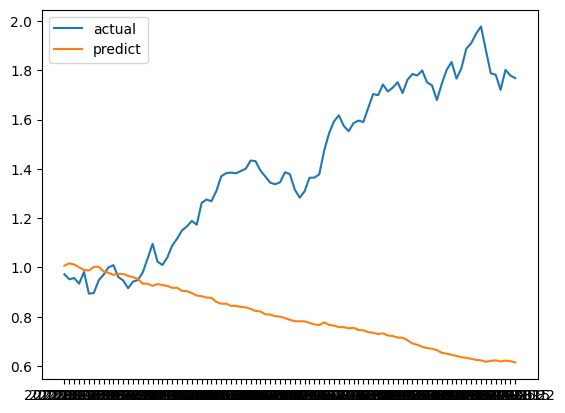

In [35]:
predicted_tuned.index = y_test.index
plt.plot(np.exp(y_test).cumprod(), label="actual")
plt.plot(np.exp(predicted_tuned).cumprod(), label="predict")
plt.legend()

### Summary

In [4]:
a = (0, 1, 2)
b = (0, 1, 2)
c = (0, 1, 2)
for x in a:
    for y in b:
        for z in c:
            print((x, y, z))

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
